In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio 
from osgeo import gdal
import json
import pandas as pd
import xarray as xr
import cdsapi
from datetime import datetime, timedelta
from time import time
import cv2
from skimage.morphology import medial_axis, skeletonize
from skimage.util import invert
import math
from matplotlib import animation
from PIL import Image
from IPython.display import Image, display

In [3]:
def access_era5(time, day, year, month, plume_lat, plume_lon, save_path): 
    """
    ## Access ERA5 reanalysis data from CDSAPI (global)
    """
    
    # Plume max concentration plus the nearest pixels on a 0.25 x 0.25 degree scale
    plume_coords = [plume_lat,plume_lon, plume_lat+0.75, plume_lon+0.75, ]
    fname_ext = '.grib'
    fname = year + month + day + '_' + time + fname_ext
    fname = os.path.join(save_path, fname)
    
    # Retrieve ERA5 from Climate Data Store (CDS) API 
    c = cdsapi.Client()
    c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'grib',
        'day': day, 
        'time': time,
        'year': year,
        'month': month,
        'area': plume_coords,
        'variable': [
            '10m_u_component_of_wind',
        ],
    },
    fname)
    
    ds = xr.open_dataset(fname)
    df = ds.to_dataframe()
    u10_avg = np.abs(np.nanmean(df['u10'])) # Positive values = eastward 
    u10_std = np.abs(np.nanstd(df['u10']))
    
    return u10_avg, u10_std

def hour_round(time): 
    """
    ## Round a time string to nearest UTC hour
    """
    
    time_obj = datetime.strptime(time, '%H:%M:%S')
    nearest_hour = (time_obj + timedelta(minutes=30)).replace(minute=0, second=0)
    rounded_time = nearest_hour.strftime('%H:%M:%S')
    return rounded_time[0:-3]

In [340]:
def calc_ime(plume_arr, plume_path, plot = False): 
    """
    plume_arr: 2-D array of plume enhancement data [ppmm]
    plume_path: filepath to plume enhancement data
    
    ime: excess mass of CH4 in plume [kg]
    p_s: dimensions of EMIT pixel [m^2]
    """

    # Get number of non-NaN pixels in a plume 
    plume_only = plume_arr[plume_arr!=-9999]
    num_pixels = plume_only.size

    #      ppm(m)     L/m^3       mole/L      kg/mole
    k = (1.0/1e6)*(1000.0/1.0)*(1.0/22.4)*(0.01604/1.0) # scaling factor from ppmm to kg CH4

    # IME calculation 
    p_s = pixel_size(plume_path)
    ime = k * np.sum([mf*p_s for mf in plume_only])
    
    if plot: 
        plt.imshow(plume_arr)
        plt.show()
    
    return ime, p_s

def pixel_size(plume_path): 
    """
    plume_path: filepath to plume enhancement data
    
    p_s: dimensions of EMIT pixel [m^2]
    """
    
    proj_ds = gdal.Warp('', plume_path, dstSRS='EPSG:3857', format='VRT')
    transform_3857 = proj_ds.GetGeoTransform()
    xsize_m = transform_3857[1]
    ysize_m = transform_3857[5]
    p_s = np.abs(xsize_m * ysize_m)
    
    return p_s 

def calc_q(plume_arr, plume_path, u10, length_flag = 'skeleton', concentric_circles = False, plot = True, gif = False): 
    """
    plume_arr [float arr]: 2-D array of plume enhancement data [ppmm]
    plume_path [str]: filepath to plume enhancement data
    u10 [float]: near surface windspeed from re-analysis data 
    length_flag [str]: type of skeletonization method ('skeleton' or 'contour')
    concentric_circles [bool]: T/F for implementing concentric circles 
    
    q [float]: hourly plume emissions [kgCH4/hr]
    ime [float]: excess mass of CH4 in plume [kg]
    """
    
    if length_flag == 'skeleton': 
        row_inds, col_inds, pixel_count, skeleton = skeletonize_plume(plume_arr)
    elif length_flag == 'contour': 
        pixel_count, _ = contour_plume(plume_arr)
    else: 
        print("Invalid plume length method selected") 

    ## CONCENTRIC CIRCLE method of emissions quantification 
    if concentric_circles: 
        # Find source pixel -> pixel with maximum concentration 
        y_max, x_max = np.unravel_index(np.argmax(plume_arr), plume_arr.shape)

        # Find contour line pixel coords closest to source
        closest_distance = float('inf')
        for i in range(len(row_inds)):
            row = row_inds[i] 
            col = col_inds[i] 

            row_distance = abs(row - y_max)
            col_distance = abs(col - x_max)
            distance = row_distance + col_distance

            # Check if this is the closest value found so far
            if distance < closest_distance:
                closest_distance = distance
                closest_row = row
                closest_col = col

        # Increase radius of concentric circle 
        radius = 5
        curr_plume_arr = np.zeros_like(plume_arr) - float('inf')

        ## OPTION 1: Start at source pixel and expand radius
        q_list = []
        rad_list = []
        ime_list = []

        if gif: 
            fig, ax = plt.subplots()

        while np.sum(curr_plume_arr > 0) < np.sum(plume_arr > 0):

            # Clip plume arr to current radius -> draw a circle with given radius from (closest_row, closest_col)
            rows, cols = np.ogrid[:plume_arr.shape[0], :plume_arr.shape[1]]
            distances = np.sqrt((rows - closest_row)**2 + (cols - closest_col)**2)    

            # Clip the array to circle
            circle_mask = distances <= radius
            curr_plume_arr = np.where(circle_mask, plume_arr, -9999)

            # IME/Q calculation
            ime, p_s = calc_ime(curr_plume_arr, plume_path)
            plume_length = 2 * radius * np.sqrt(p_s) 
            q = (ime/plume_length) * u10 * 3600

            q_list.append(q)
            rad_list.append(radius)
            ime_list.append(ime)
            
            if gif:
                # Save for gifs 
                curr_fig = ax.imshow(curr_plume_arr)
                frames.append([curr_fig])

            radius += 5

        if plot:
            # Plot concentric circle IME/Q data
            fig, ax1 = plt.subplots()
            ax1.scatter(rad_list, q_list, color = 'blue')
            ax1.set_xlabel('Concentric circle radius [pixels]')
            ax1.set_ylabel('Q [kgCH4/hr]', color = 'blue')
            ax1.tick_params(axis = 'y', labelcolor = 'blue')
            ax2 = ax1.twinx()
            ax2.scatter(rad_list, ime_list, color = 'r')
            ax2.set_ylabel('IME [kg]', color = 'r')
            ax2.tick_params(axis = 'y', labelcolor = 'r')
            plt.show()

            # Plot original plume + skeletonized + source pixel
            plt.imshow(plume_arr, cmap = 'viridis')
            masked = np.ma.masked_where(skeleton == 0, skeleton)
            plt.imshow(masked, cmap = 'hsv')
            plt.scatter(x_max, y_max, marker = 'x', color = 'blue')
            plt.show()
            
        if gif: 
            # Display animation of concentric circles 
            ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True, repeat_delay=1000)
            ani.save('test.gif')
            display(Image('test.gif'))
            
        return ime_list, q_list

    ## EMISSIONS QUANTIFICATION OF WHOLE PLUME
    else: 
        plume_length = pixel_count*np.sqrt(p_s) 
        ime, p_s = calc_ime(plume_arr, plume_path)
        q = (ime/plume_length) * u10

        return ime, q

def skeletonize_plume(plume_arr, plot = False): 

    # Scale plume 0-1
    min_plume = np.min(plume_arr)
    max_plume = np.max(plume_arr)
    scale_plume = (plume_arr - min_plume)/(max_plume - min_plume)
    scale_plume = (scale_plume * 255).astype(np.uint8)

    # Create binary threshold of plume/background
    img = 255 - scale_plume
    _, threshold = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Skeletonize
    curr = invert(threshold)/255
    skeleton = skeletonize(curr)
    skeleton = skeleton.astype(int)

    # Get indices of skeleton line
    row_inds, col_inds = np.nonzero(skeleton)
    pixel_count = np.count_nonzero(skeleton) 

    # Plotting
    if plot: 
        plt.imshow(img, cmap = plt.cm.gray)
        masked = np.ma.masked_where(skeleton == 0, skeleton)
        plt.imshow(masked, cmap = 'hsv')
        plt.show()
        
    return row_inds, col_inds, pixel_count, skeleton

def contour_plume(plume_arr, plot = True): 

    # Scale 0-1
    min_plume = np.min(plume_arr)
    max_plume = np.max(plume_arr)
    scale_plume = (plume_arr - min_plume)/(max_plume - min_plume)
    scale_plume = (scale_plume * 255).astype(np.uint8)

    # Create binary threshold of plume/background
    img = 255 - scale_plume
    a = img.max()  
    _, thresh = cv2.threshold(img, a/2+60, a,cv2.THRESH_BINARY_INV)

    # Find the contour of the plume 
    contours, hierarchy = cv2.findContours(
                                       image = thresh, 
                                       mode = cv2.RETR_TREE, 
                                       method = cv2.CHAIN_APPROX_NONE)

    # Sort the contours 
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    c = contours[0]

    # Calculate line through plume
    img_copy = np.stack((img,)*3, axis = -1) # create a 3-channel image for displaying contour
    rows,cols = img_copy.shape[:2]
    [vx,vy,x,y] = cv2.fitLine(c, cv2.DIST_L2,0,0.01,0.01)
    left_pt = int((-x*vy/vx) + y)
    right_pt = int(((cols-x)*vy/vx)+y)
    cv2.line(img_copy,(cols-1,right_pt),(0,left_pt),(0,0,255),1)
    line_length = math.dist([cols-1,right_pt],[0,left_pt])

    # Plotting
    if plot: 
        M = cv2.moments(c)
        cX = int(M["m10"]/M["m00"])
        cY = int(M["m01"]/M["m00"])
        cv2.circle(img_copy, (cX, cY), 1, (255, 0, 0), -1)
        cv2.drawContours(image=img_copy, contours=contours, 
                         contourIdx=-1, color=(0, 255, 0), thickness=1)
        plt.imshow(img_copy, cmap = 'gray')
        plt.show()

    area = cv2.contourArea(c)
    return line_length, area

## IME + Emissions Calcuations

2023-09-13 14:48:04,550 INFO Welcome to the CDS
2023-09-13 14:48:04,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-09-13 14:48:04,823 INFO Request is completed
2023-09-13 14:48:04,825 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data3/adaptor.mars.internal-1694638488.6568418-29488-14-6a16aa8d-8f76-4fff-8696-82921418812e.grib to /scratch/colemanr/emit-ghg/grib/20220815_14:00.grib (240)
2023-09-13 14:48:05,810 INFO Download rate 243.7/s                                             
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220815_14:00.grib.923a8.idx' older than GRIB file


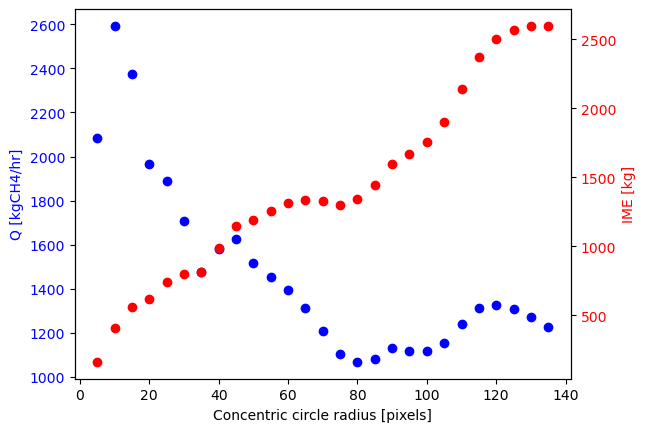

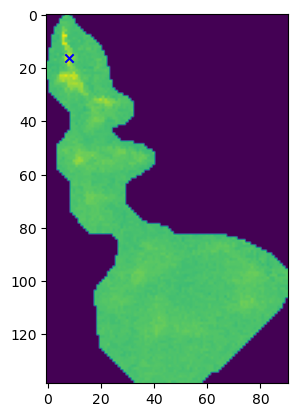

2023-09-13 14:48:06,635 INFO Welcome to the CDS
2023-09-13 14:48:06,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-497
/scratch/brodrick/methane/visions_delivery/20220815/l2bch4plm/emit20220815t140823_CH4_PlumeComplex-497.tif
IME [kg]: [163.54470308814908, 407.39276003389716, 559.2931298582108, 617.3727646743476, 741.3502352711321, 803.7698921263365, 812.4249180961457, 992.0243217924647, 1148.0480068643512, 1191.3585242136544, 1256.3800190447744, 1313.8855656933163, 1339.0621684165362, 1327.9125661959988, 1301.5046823446783, 1340.6955535251827, 1445.1698339653722, 1595.1415939538726, 1669.2375080623212, 1754.280043425322, 1900.9196231598892, 2140.2664084456073, 2369.286006951646, 2498.9900988869394, 2568.9989929739704, 2596.193554152088, 2596.805269317367]
Q [kgCH4/hr]: [2082.1096126969082, 2593.286012303653, 2373.47868809802, 1964.9639267938971, 1887.6459122019594, 1705.4837680380076, 1477.5844154284748, 1578.6993841982876, 1623.9948438109977, 1516.7345616180949, 1454.10391023931, 1393.9378218195168, 1311.3677367306211, 1207.5595351388752, 1104.64207804162, 1066.7859639384828, 108

2023-09-13 14:48:06,892 INFO Request is completed
2023-09-13 14:48:06,893 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data3/adaptor.mars.internal-1694638567.3875027-16975-4-f2e7cacf-728d-4978-ad42-6aec89f5c48d.grib to /scratch/colemanr/emit-ghg/grib/20220816_04:00.grib (240)
2023-09-13 14:48:07,870 INFO Download rate 245.8/s                                             
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220816_04:00.grib.923a8.idx' older than GRIB file


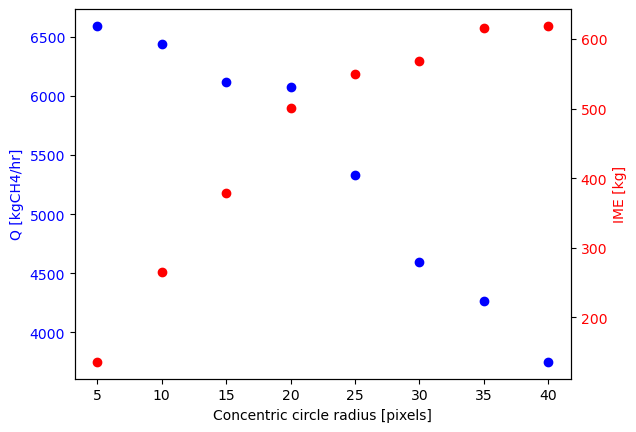

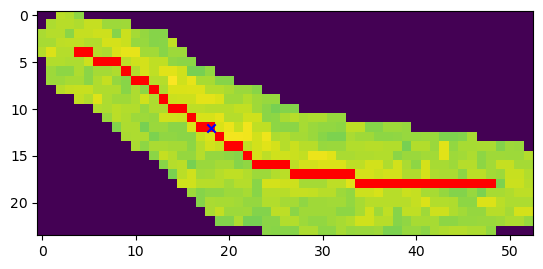

2023-09-13 14:48:08,573 INFO Welcome to the CDS
2023-09-13 14:48:08,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-741
/scratch/brodrick/methane/visions_delivery/20220816/l2bch4plm/emit20220816t034409_CH4_PlumeComplex-741.tif
IME [kg]: [135.982229414745, 265.6054018370755, 378.4987504589477, 501.57702827965306, 549.6710383711661, 569.0962443405979, 615.8986453261073, 618.8439396833986]
Q [kgCH4/hr]: [6592.413283398322, 6438.26986345622, 6116.534984054981, 6079.108788901233, 5329.606185239524, 4598.294028161012, 4265.534682782596, 3750.1913171650563]
U10 avg [m/s]: 8.839065
U10 std [m/s]: 0.67369735
Time [s]: 1.939201


2023-09-13 14:48:08,800 INFO Request is completed
2023-09-13 14:48:08,802 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data4/adaptor.mars.internal-1694638575.2369065-4936-17-29e3ea42-18ab-4c3c-8044-11c039d8844b.grib to /scratch/colemanr/emit-ghg/grib/20220816_10:00.grib (240)
2023-09-13 14:48:10,003 INFO Download rate 200/s                                               
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220816_10:00.grib.923a8.idx' older than GRIB file


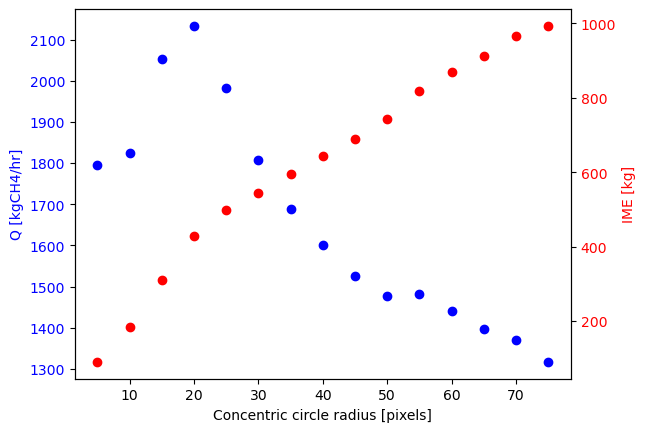

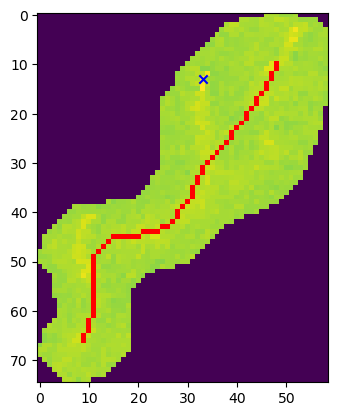

2023-09-13 14:48:10,752 INFO Welcome to the CDS
2023-09-13 14:48:10,753 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-500
/scratch/brodrick/methane/visions_delivery/20220816/l2bch4plm/emit20220816t101058_CH4_PlumeComplex-500.tif
IME [kg]: [90.24547888058522, 183.4824716047029, 309.4745568012031, 428.90876840523475, 498.3063879949736, 545.0110457757088, 594.1430196651803, 644.0039332259131, 689.8359235616563, 742.7979843326151, 819.1213459918409, 869.2460670800164, 912.5048778405834, 964.7212481322322, 992.7728355393539]
Q [kgCH4/hr]: [1795.402826680962, 1825.1603972393743, 2052.2966947442746, 2133.248182443505, 1982.726910326866, 1807.1346145639905, 1688.6102062815046, 1601.529650639663, 1524.8943246201272, 1477.771094204481, 1481.4670932001784, 1441.112678879877, 1396.4593337374163, 1370.9141502080906, 1316.7249870677554]
U10 avg [m/s]: 3.9814732
U10 std [m/s]: 0.3514011
Time [s]: 2.179164


2023-09-13 14:48:11,008 INFO Request is completed
2023-09-13 14:48:11,009 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data2/adaptor.mars.internal-1694638582.5012264-5317-17-254b4365-98a9-46cf-b496-1c5064c5ca5f.grib to /scratch/colemanr/emit-ghg/grib/20220816_10:00.grib (240)
2023-09-13 14:48:12,171 INFO Download rate 206.9/s                                             
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220816_10:00.grib.923a8.idx' older than GRIB file


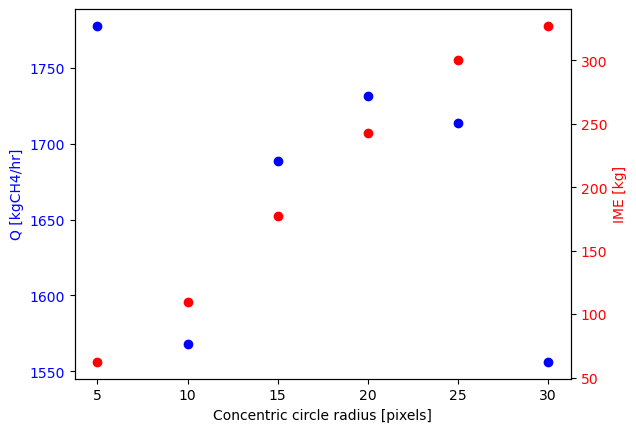

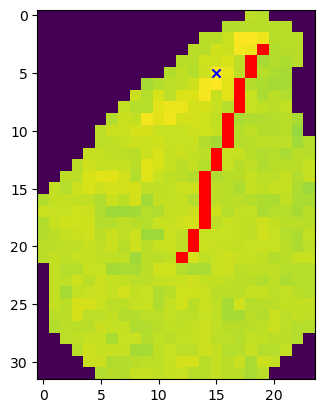

2023-09-13 14:48:13,302 INFO Welcome to the CDS
2023-09-13 14:48:13,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-502
/scratch/brodrick/methane/visions_delivery/20220816/l2bch4plm/emit20220816t101035_CH4_PlumeComplex-502.tif
IME [kg]: [62.2878050414952, 109.86732985886411, 177.5156336669069, 242.71777376667927, 300.23157974624377, 327.12639688241455]
Q [kgCH4/hr]: [1777.8408683224527, 1567.9363639995713, 1688.904958142501, 1731.9344347708907, 1713.8634828384086, 1556.1598215926542]
U10 avg [m/s]: 5.7795515
U10 std [m/s]: 0.11343153
Time [s]: 2.550252


2023-09-13 14:48:13,524 INFO Request is completed
2023-09-13 14:48:13,525 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data0/adaptor.mars.internal-1694638589.870617-31902-17-80d1a687-0020-4be2-bd4c-cf787b4b312d.grib to /scratch/colemanr/emit-ghg/grib/20220816_12:00.grib (240)
2023-09-13 14:48:14,654 INFO Download rate 212.8/s                                             
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220816_12:00.grib.923a8.idx' older than GRIB file


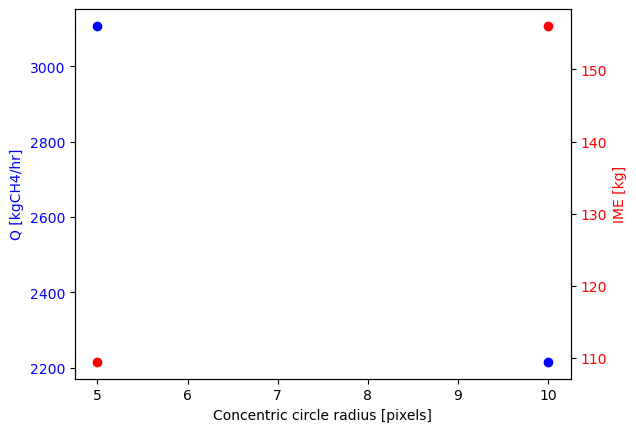

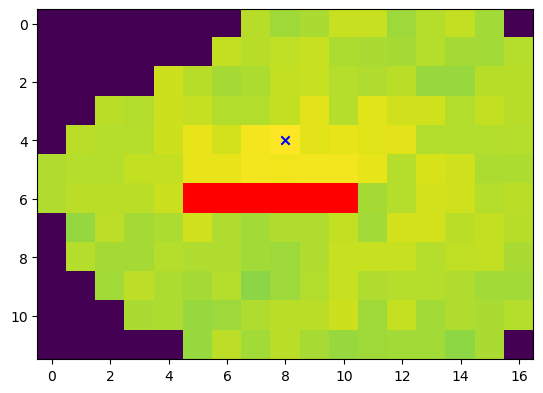

2023-09-13 14:48:15,341 INFO Welcome to the CDS
2023-09-13 14:48:15,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-498
/scratch/brodrick/methane/visions_delivery/20220816/l2bch4plm/emit20220816t114505_CH4_PlumeComplex-498.tif
IME [kg]: [109.43572526724532, 156.03300300145833]
Q [kgCH4/hr]: [3107.251710343248, 2215.1532978024125]
U10 avg [m/s]: 5.1662383
U10 std [m/s]: 0.6377715
Time [s]: 2.038828


2023-09-13 14:48:15,567 INFO Request is completed
2023-09-13 14:48:15,569 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data0/adaptor.mars.internal-1694638595.7143452-25412-19-e276dc6a-38f6-46e1-9a31-3c6143d3f54e.grib to /scratch/colemanr/emit-ghg/grib/20220817_05:00.grib (240)
2023-09-13 14:48:16,684 INFO Download rate 215.4/s                                             
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220817_05:00.grib.923a8.idx' older than GRIB file


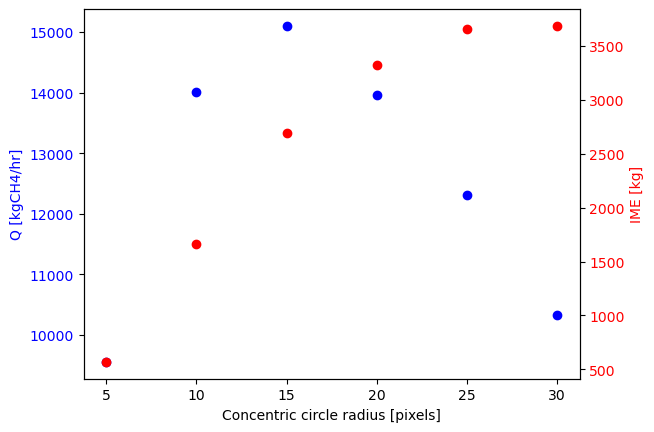

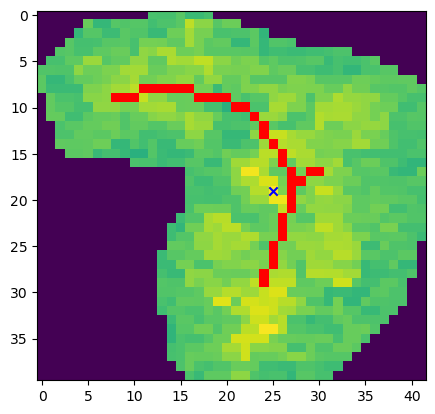

2023-09-13 14:48:17,835 INFO Welcome to the CDS
2023-09-13 14:48:17,837 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-743
/scratch/brodrick/methane/visions_delivery/20220817/l2bch4plm/emit20220817t043235_CH4_PlumeComplex-743.tif
IME [kg]: [568.6880838720987, 1667.4743101158472, 2695.49171146774, 3323.4857541742235, 3661.3448505149368, 3687.0806862806808]
Q [kgCH4/hr]: [9556.621506729627, 14010.686442971279, 15098.958926441175, 13962.528992780084, 12305.54602225648, 10326.702101100638]
U10 avg [m/s]: 3.6592953
U10 std [m/s]: 0.49923235
Time [s]: 2.493952


2023-09-13 14:48:18,069 INFO Request is completed
2023-09-13 14:48:18,071 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data6/adaptor.mars.internal-1694629604.8998578-27492-3-fd5e47c7-236f-459b-b16d-d06a7ad5aa4d.grib to /scratch/colemanr/emit-ghg/grib/20220817_05:00.grib (240)
2023-09-13 14:48:19,240 INFO Download rate 205.4/s                                             
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220817_05:00.grib.923a8.idx' older than GRIB file


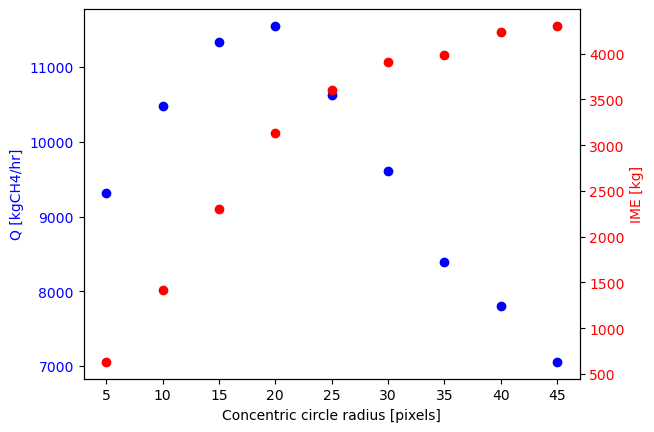

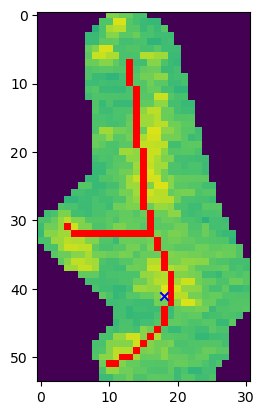

2023-09-13 14:48:19,941 INFO Welcome to the CDS
2023-09-13 14:48:19,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-744
/scratch/brodrick/methane/visions_delivery/20220817/l2bch4plm/emit20220817t043235_CH4_PlumeComplex-744.tif
IME [kg]: [631.2219794002034, 1419.8693099406942, 2304.567025787237, 3130.78824691233, 3601.772768667394, 3907.140857096359, 3982.116938027089, 4233.575948749661, 4303.109011859777]
Q [kgCH4/hr]: [9314.096941992135, 10475.554424066082, 11335.135862398802, 11549.211762358053, 10629.306907935183, 9608.740373603978, 8394.109114780937, 7808.650935168932, 7055.023746956154]
U10 avg [m/s]: 3.5732384
U10 std [m/s]: 0.50034213
Time [s]: 2.106343


2023-09-13 14:48:20,162 INFO Request is completed
2023-09-13 14:48:20,163 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data5/adaptor.mars.internal-1694629640.2311645-29566-12-b7f5e3b2-c9e2-4b5a-9b08-271935bb2cb0.grib to /scratch/colemanr/emit-ghg/grib/20220817_09:00.grib (240)
2023-09-13 14:48:20,346 INFO Download rate 1.3K/s                                              
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220817_09:00.grib.923a8.idx' older than GRIB file


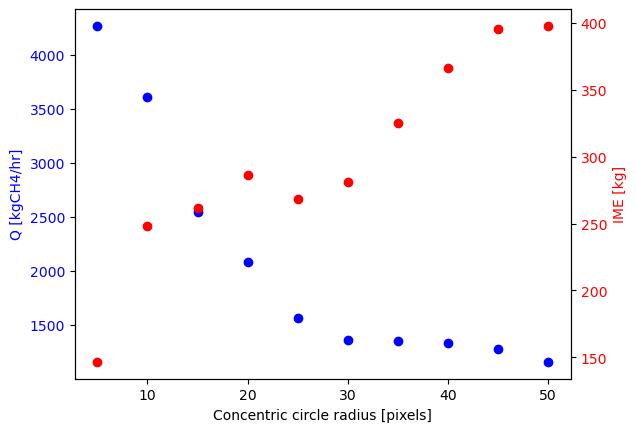

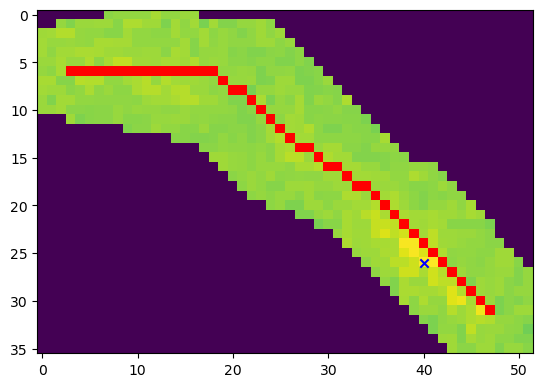

2023-09-13 14:48:21,062 INFO Welcome to the CDS
2023-09-13 14:48:21,063 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-503
/scratch/brodrick/methane/visions_delivery/20220817/l2bch4plm/emit20220817t092038_CH4_PlumeComplex-503.tif
IME [kg]: [146.44593705825673, 248.0417421192109, 262.0009323413799, 286.49786340529914, 268.1513326288985, 281.345485276385, 324.984320272914, 366.3631994814176, 395.88091759129344, 397.8940720642989]
Q [kgCH4/hr]: [4264.772749958092, 3611.7139331128387, 2543.3149806189467, 2085.8350619281437, 1561.8111628535585, 1365.548933430121, 1352.019436664903, 1333.645559857919, 1280.9749177269007, 1158.7400989039659]
U10 avg [m/s]: 5.635372
U10 std [m/s]: 0.263356
Time [s]: 1.120012


2023-09-13 14:48:21,267 INFO Request is completed
2023-09-13 14:48:21,268 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data8/adaptor.mars.internal-1694638605.8557913-17437-9-4fa1773e-3f96-4859-a8d1-0373dd4a962d.grib to /scratch/colemanr/emit-ghg/grib/20220818_04:00.grib (240)
2023-09-13 14:48:22,443 INFO Download rate 204.5/s                                             
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220818_04:00.grib.923a8.idx' older than GRIB file


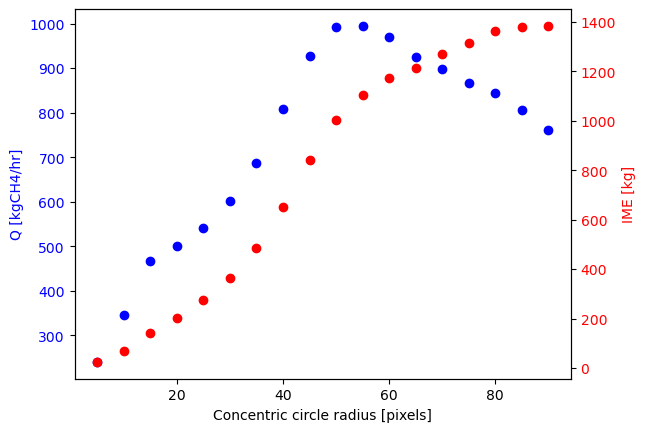

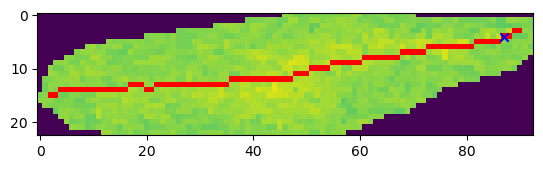

2023-09-13 14:48:23,168 INFO Welcome to the CDS
2023-09-13 14:48:23,170 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-507
/scratch/brodrick/methane/visions_delivery/20220818/l2bch4plm/emit20220818t034231_CH4_PlumeComplex-507.tif
IME [kg]: [24.2909792562506, 70.06577677665022, 141.6479624988099, 201.85254634113673, 273.41328565942547, 364.00842584199904, 485.502222281605, 653.2791726530797, 843.0414365519533, 1001.5468047104894, 1104.530475863902, 1173.9758902614863, 1214.8343870421704, 1269.5206702160954, 1313.5585903473911, 1361.7264328806202, 1381.375464022224, 1384.1135173355644]
Q [kgCH4/hr]: [240.63135272351397, 347.04287685418575, 467.73112036158307, 499.8980358547593, 541.6974596763399, 600.9901795854101, 687.0690277093155, 808.9394491020661, 927.9265503801288, 992.1525183937681, 994.7002051018032, 969.1368812207683, 925.7227004856962, 898.2948918782936, 867.4918019084517, 843.0960885899425, 804.9520407898291, 761.7393557360137]
U10 avg [m/s]: 1.7134638
U10 std [m/s]: 0.46627295
Time [s]: 2.107084


2023-09-13 14:48:23,393 INFO Request is completed
2023-09-13 14:48:23,394 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data6/adaptor.mars.internal-1694638616.292081-30456-12-0c9c9d39-0d4e-4eeb-91f8-f33d2a33ca77.grib to /scratch/colemanr/emit-ghg/grib/20220818_07:00.grib (240)
2023-09-13 14:48:23,580 INFO Download rate 1.3K/s                                              
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220818_07:00.grib.923a8.idx' older than GRIB file


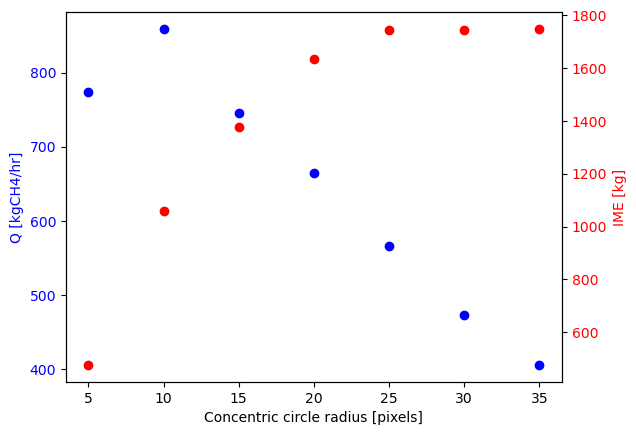

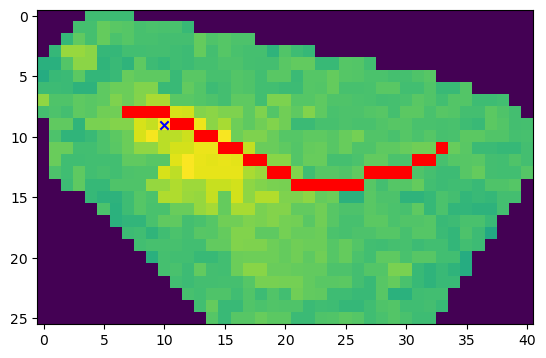

CH4_PlumeComplex-508
/scratch/brodrick/methane/visions_delivery/20220818/l2bch4plm/emit20220818t070105_CH4_PlumeComplex-508.tif
IME [kg]: [476.0873320554779, 1057.2912517231778, 1377.4063701951034, 1635.1707340409068, 1742.7529832257658, 1744.9310434906004, 1748.5139334465523]
Q [kgCH4/hr]: [773.4829988999987, 858.8726826260944, 745.9418599543277, 664.1516576480184, 566.2783750147357, 472.48841599631055, 405.821642314948]
U10 avg [m/s]: 0.30676174
U10 std [m/s]: 0.78020567
Time [s]: 1.127315


In [358]:
# Path to delineated plume COGs 
plume_path = '/scratch/brodrick/methane/visions_delivery/'

# Path to plume metadata (.json) 
metadata_path = '/scratch/brodrick/methane/visions_delivery/combined_plume_metadata.json'

# Open plume metadata as nested json dict
f = open(metadata_path)
metadata = json.load(f)
plume_df = pd.json_normalize(metadata['features'])

# Remove duplicate plume metadata "Point" entries 
poly_df = plume_df[plume_df['geometry.type'] == 'Polygon']
plume_id_list = list(poly_df['properties.Plume ID'])
scene_fid_list = list(poly_df['properties.Scene FIDs'])
save_path = '/scratch/colemanr/emit-ghg/grib'

# Emissions calculation for all plumes on cluster 
for i in range(len(plume_id_list))[10:20]:
    
    start = datetime.now()
    
    plume_id = plume_id_list[i]
    scene_fid = scene_fid_list[i]
    
    if len(scene_fid) < 2: 
        for fid in scene_fid:
            curr_folder = os.path.join(fid[4:12], 'l2bch4plm')
            curr_file = fid + '_' + plume_id + '.tif'
            full_path = os.path.join(plume_path, curr_folder, curr_file)

            # Get plume metadata properties
            sub_df = poly_df[poly_df['properties.Plume ID'] == plume_id]
            obs = list(sub_df['properties.UTC Time Observed'])[0]
            day = obs[8:10]
            time = hour_round(obs[11:19])
            year = obs[0:4]
            month = obs[5:7]
            plume_lat = list(sub_df['properties.Latitude of max concentration'])[0]
            plume_lon = list(sub_df['properties.Longitude of max concentration'])[0]

            # Load plume as 2D array
            with rasterio.open(full_path, 'r') as ds: 
                plume_arr = ds.read().squeeze()

            # IME and Q calculations, get ERA5 u10 data from CDSAPI
            u10_avg, u10_std = access_era5(time, day, year, month, plume_lat, plume_lon, save_path)
            ime, q = calc_q(plume_arr, full_path, u10_avg, length_flag = 'skeleton', concentric_circles = True, plot = True)
            print(plume_id)
            print(full_path)
            print('IME [kg]:', ime)
            print('Q [kgCH4/hr]:', q)
            print('U10 avg [m/s]:', u10_avg)
            print('U10 std [m/s]:', u10_std)
            
    else: # Ignore any plumes that cover multiple scenes 
        print('Skipping', plume_id)
        
    stop = datetime.now()
    print('Time [s]:', (stop-start).total_seconds())

### EXPERIMENTAL: Plume length determination 

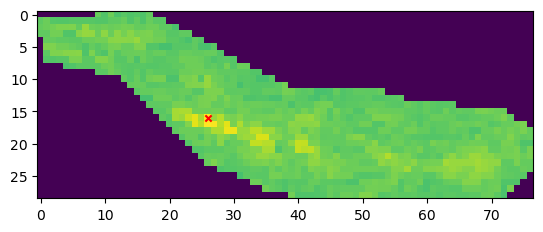

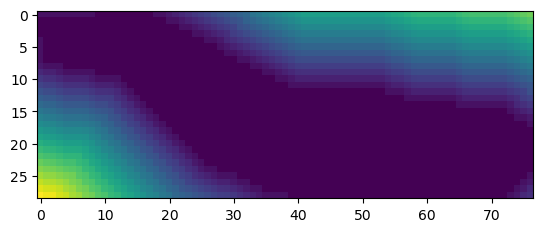

In [10]:
blob_path = '/scratch/brodrick/methane/visions_delivery/20220810/l2bch4plm/emit20220810t065021_CH4_PlumeComplex-486.tif'
gaussian_path = '/scratch/brodrick/methane/visions_delivery/20220810/l2bch4plm/emit20220810t065132_CH4_PlumeComplex-487.tif'

with rasterio.open(blob_path, 'r') as ds: 
    blob_plume = ds.read().squeeze()

with rasterio.open(gaussian_path, 'r') as ds: 
    gaussian_plume = ds.read().squeeze()

## Plume plot with highlighted point of max concentration
plume = gaussian_plume
max_index = np.unravel_index(np.argmax(plume), plume.shape)
plt.imshow(plume)
plt.scatter(max_index[1], max_index[0], c='red', marker = 'x', s=20)
plt.show()

plume_arr = gaussian_plume

# Scale plume 0-1
min_plume = np.min(plume_arr)
max_plume = np.max(plume_arr)
scale_plume = (plume_arr - min_plume)/(max_plume - min_plume)
scale_plume = (scale_plume * 255).astype(np.uint8)

# Create binary threshold of plume/background
img = 255 - scale_plume
_, threshold = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Distance transform of contour -> ridge detection?
_, threshold = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
dist = cv2.distanceTransform(threshold, cv2.DIST_L2, 3)
dist_output = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

plt.imshow(dist_output)
plt.show()

### Experimental HRRR code

In [41]:
from herbie import Herbie

model_run_date = year + '-' + month + '-' + day + ' ' + time
model_name = 'hrrr'

H = Herbie(
    model_run_date,  # model run date
    model="hrrr",  # model name
    fxx=0,  # forecast lead time
)

# U and V wind at 10-m above ground
H.PRODUCTS
ds = H.xarray(":UGRD:10 m")

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-18 07:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws


In [56]:
min_lat_hrrr = float(np.min(ds.latitude))
max_lat_hrrr = float(np.max(ds.latitude))
min_lon_hrrr = float(np.min(ds.longitude))
max_lon_hrrr = float(np.max(ds.longitude))

# Check to see if plume in CONUS/HRRR range 
hrrr_cond = min_lat_hrrr <= plume_lat <= max_lat_hrrr and min_lat_hrrr <= plume_lon <= max_lat_hrrr

if hrrr_cond: 
    # Find average windspeed around plume 